# Fourth assignment: Network Robustness

In this assignment, we investigate the robustness of a network by simulating random failures and target attacks; we use different graphs: a random graph (with a connected regime), a scale-free graph (generated by the Barabasi-Albert model) and finally a real graph (Arxiv GR-QC).

Other than developing random failures, we focus also on target attacks in order to see which node removal strategy causes the most damage: we try to remove the node with the highest degree, closeness, betweenness, clustering coefficient, PageRank, and HITS score.

For each graph, we observe how these different failures affect the diameter, the average degree of the network and the size of the giant component (number of links).
We expect that the attack tolerance to random failures is much higher with respect to the target attacks: the fraction of nodes to remove in order to break the giant component is greater in the first case than in the second.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import multiprocessing

## 0. Failure utilities

In [2]:
def parallel_work(graph, idx, diam, deg, giant, verbose=True):
    diam[idx] = nx.diameter(graph)
    deg[idx] = np.mean(list(dict(graph.degree).values()))
    giant[idx] = graph.size()
    if verbose:
        print("Iteration {}:\tGraph size: {};\tDiameter: {}".format(idx, len(graph), diam[idx]))

def execute_failures_pool(graph, rankFunction, rankParams={}):
    workingG = max(nx.connected_component_subgraphs(graph), key=len)
    
    i = 0
    diam_evol = multiprocessing.Manager().dict({i:nx.diameter(workingG)})
    deg_evol = multiprocessing.Manager().dict({i:np.mean(list(dict(workingG.degree).values()))})
    giant_evol = multiprocessing.Manager().dict({i:workingG.size()})
    
    pool = multiprocessing.Pool(processes=4)

    while len(workingG)>1:
        node = rankFunction(workingG, **rankParams)
        workingG.remove_node(node)
        workingG = max(nx.connected_component_subgraphs(workingG), key=len)
        
        i+=1
        pool.apply_async(func=parallel_work, args=(workingG.copy(),i,diam_evol,deg_evol,giant_evol))
        
    pool.close()
    pool.join()
    
    diam_evol = list(map(lambda p:p[1], sorted(diam_evol.items(), key=lambda p:p[0])))
    deg_evol = list(map(lambda p:p[1], sorted(deg_evol.items(), key=lambda p:p[0])))
    giant_evol = list(map(lambda p:p[1], sorted(giant_evol.items(), key=lambda p:p[0])))
    
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}

def execute_failures_seq(graph, rankFunction, rankParams={}):
    workingG = max(nx.connected_component_subgraphs(graph), key=len)

    diam_evol = [nx.diameter(workingG)]
    deg_evol = [np.mean(list(dict(workingG.degree).values()))]
    giant_evol = [workingG.size()]
    
    i=0
    while len(workingG)>1:
        node = rankFunction(workingG, **rankParams)
        workingG.remove_node(node)
        workingG = max(nx.connected_component_subgraphs(workingG), key=len)
        i+=1
        print("Iteration {}: graph size {}\n\tprevious diam: {}".format(i, len(workingG), diam_evol[i-1]))


        diam_evol.append(nx.diameter(workingG))
        deg_evol.append(np.mean(list(dict(workingG.degree).values())))
        giant_evol.append(workingG.size())
    
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}

def plot_distribution(failDict, title):
    plt.figure(figsize=(15,8))
    plt.suptitle("{} failures evolution".format(title))
 
    plt.subplot(121)
    plt.plot(failDict["Diameter evolution"], label="Diameter evolution")
    plt.plot(failDict["Average degree evolution"], label="Average degree evolution")
    plt.xlabel("#failures")
    plt.ylabel("value")
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(failDict["Giant component evolution"], label="Giant component evolution")
    plt.xlabel("#failures")
    plt.ylabel("GC size (edges)")
    plt.legend()
    plt.grid()
    
def compare_attack(failDict, network):
    plt.figure(figsize=(15,8))
    plt.title("Evolution Comparison between different attack in a {} graph".format(network))
    plt.xlabel("#failures")
    plt.ylabel("GC size")
    for attack, evolution in failDict.items():
        plt.plot(evolution, label=attack)
    plt.legend()
    plt.grid()
    
def compare_attack2(failDict, network):
    title = "Evolution Comparison between different attack in a {} graph".format(network)
    
    layout = go.Layout(
        title=go.layout.Title(text=title),
        xaxis=go.layout.XAxis(
            title=go.layout.xaxis.Title(text="#failures")
        ),
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(text="GC size (edges)")
        )
    )
    
    data = []
    for attack, evolution in failDict.items():
        trace = go.Scatter(
            y=evolution,
            name=attack,
        )
        data.append(trace)
        
    return py.iplot(go.Figure(data=data, layout=layout), filename=title)

In [3]:
def random_ranking(graph):
    #return list(zip(np.random.permutation(graph.nodes()),range(1,graph.number_of_nodes()+1)))
    return np.random.choice(graph.nodes())

def metric_ranking(graph, metricFunction, index=None):
    if index is None:
        metricDict = dict(metricFunction(graph))
    else:
        metricDict = dict(metricFunction(graph)[index])
    
    return max(metricDict.items(), key=lambda pair:pair[1])[0]

## 1. Erdős-Rényi random graph $[G_{np}]$
<h4>Connected regime $\left[p>\frac{\log{n}}{n}\right]$</h4>

In [4]:
n = 300
attackDict = {}

In [5]:
G = nx.gnp_random_graph(n,np.log(n*2)/n)
pos = nx.spring_layout(G)
print("log(n)={}, <k>={}".format(round(np.log(100),2), np.mean(list(map(lambda item:item[1], G.degree)))))

log(n)=4.61, <k>=6.593333333333334


/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


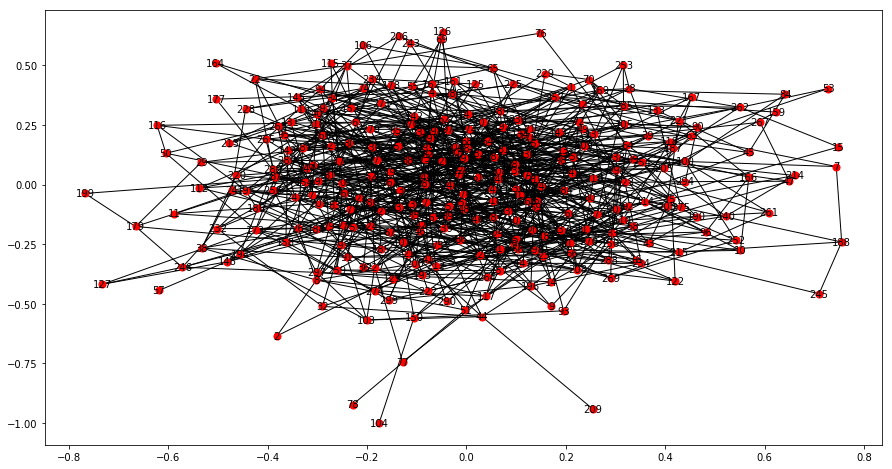

In [6]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random failures

In [ ]:
rand_failures = execute_failures_pool(G, random_ranking)

In [ ]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

From the graph, we can observe that diameter increases, then decrease until it reaches a critical point in which collapse to zero (the giant component vanishes); it could be also observed that, when the giant component vanishes, the average degree become zero.
(In random failures comparing the total number of nodes with those eliminated, we could see that it requires the elimination of more than 70% of nodes in order to disrupt the giant component: in this case, the critical fraction of node is near 220 out of 300 total nodes).

### -- attacks over closeness

In [ ]:
cls_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.closeness_centrality})

In [ ]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweenness

In [ ]:
btw_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.betweenness_centrality})

In [ ]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over nodes degree

In [ ]:
deg_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.degree})

In [ ]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Degree-guided")

### -- attacks over clustering coefficient

In [ ]:
clt_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.clustering})

In [ ]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [ ]:
prk_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.pagerank_numpy})

In [ ]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [ ]:
hit_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.hits_numpy, 'index':0})

In [ ]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

Observing plots from other kinds of attacks we should observe that the fraction required to “break” the giant component is less w.r.t the random failures.

The smallest fraction required in terms of the node is obtained deleting nodes with the highest betweenness, closeness and node degree (in this small test random graph most likely they end up being eventually the same nodes).

But the most interesting consideration is about the diameter evolution in the closeness guided attack: for this kind of graph, we are able to obtain a value that is two times greater than the other experiments.

### -- attack comparison

In [ ]:
compare_attack(attackDict, "Random")

From this comparison plot, we could confirm what we have already stated: random failures require more node to delete in order to make the giant component vanishes; the worst target attack is that based on PageRank, this is probably due to the random network structure, which has very few hubs.

Again, the best target attack is which that delete nodes based on the betweenness.

## 2. Power law network

In [ ]:
n = 300
attackDict = {}

In [ ]:
G = nx.barabasi_albert_graph(n,2)
pos = nx.spring_layout(G)
print("<k>={}".format(np.mean(list(map(lambda item:item[1], G.degree)))))

In [ ]:
plt.figure(figsize=(15,8))
nx.draw_networkx(G,pos,font_size=10,node_size=50)

### -- random failures

In [ ]:
rand_failures = execute_failures_pool(G, random_ranking)

In [ ]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

As discussed above, random failures spend more time compared to the targeted attack.

The critical fraction of nodes is less compared with the fraction required for the random network: this is due to the fact that in this graph there is the presence of hubs and if someone is selected, their removing affects a lot the diameter and the giant component size.

### -- attacks over closeness

In [ ]:
cls_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.closeness_centrality})

In [ ]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweennes

In [ ]:
btw_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.betweenness_centrality})

In [ ]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over nodes degree

In [ ]:
deg_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.degree})

In [ ]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Degree-guided")

### -- attacks over clustering coefficient

In [ ]:
clt_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.clustering})

In [ ]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [ ]:
prk_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.pagerank_numpy})

In [ ]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [ ]:
hit_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.hits_numpy, 'index':0})

In [ ]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

In the other attacks, the fraction of nodes is lower, especially in the betweenness and closeness cases: this remarks the fact that hubs are of fundamental importance in terms of communication.

### -- attack comparison

In [ ]:
compare_attack(attackDict, "power-law")

In this last plot, random failures require the deletion of more node (as expected), whereas the attacks based on the other centrality measures, above all betweenness, require fewer failures.

The clustering coefficient guided attacks perform worst with respect the others: the lower clustering coefficient, the more importance a node have (this is an indicator of structural holes and so of the dissortative “hubs” characteristic of the node).

## 3. Real Graph - arXiv collaboration on general relativity

In [4]:
attackDict = {}

In [5]:
G = nx.Graph()
edges = nx.read_edgelist('../datasets/dataset.txt')
G.add_edges_from(edges.edges())
posTotal = nx.spring_layout(G)

Number of nodes: 5242
Number of edges: 14496


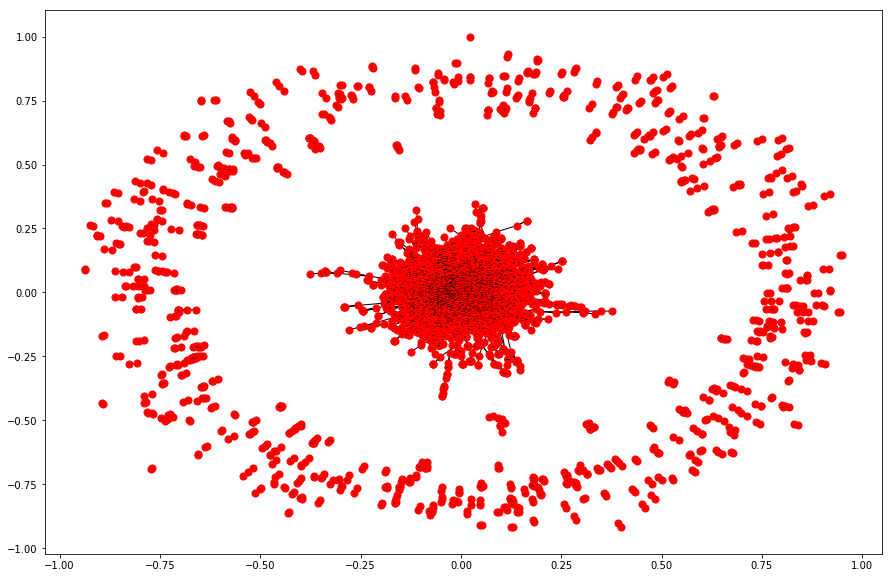

In [9]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G, posTotal, font_size=0, node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### -- random failures

In [10]:
rand_failures = execute_failures_pool(G, random_ranking)

Iteration 1: graph size 4157
	previous diam: 17
Iteration 3: graph size 4155
	previous diam: 17
Iteration 4: graph size 4154
	previous diam: 17
Iteration 2: graph size 4156
	previous diam: 17
Iteration 5: graph size 4153
	previous diam: 17
Iteration 6: graph size 4152
	previous diam: 17
Iteration 7: graph size 4149
	previous diam: 17
Iteration 8: graph size 4147
	previous diam: 17
Iteration 9: graph size 4146
	previous diam: 17
Iteration 10: graph size 4145
	previous diam: 17
Iteration 11: graph size 4144
	previous diam: 17
Iteration 12: graph size 4143
	previous diam: 17
Iteration 13: graph size 4142
	previous diam: 17
Iteration 14: graph size 4141
	previous diam: 17
Iteration 15: graph size 4140
	previous diam: 17
Iteration 16: graph size 4139
	previous diam: 17
Iteration 17: graph size 4138
	previous diam: 17
Iteration 18: graph size 4137
	previous diam: 17
Iteration 19: graph size 4136
	previous diam: 17
Iteration 20: graph size 4135
	previous diam: 17
Iteration 21: graph size 4134

	previous diam: 18
Iteration 168: graph size 3894
	previous diam: 18
Iteration 169: graph size 3893
	previous diam: 18
Iteration 170: graph size 3892
	previous diam: 18
Iteration 171: graph size 3891
	previous diam: 18
Iteration 172: graph size 3890
	previous diam: 18
Iteration 173: graph size 3889
	previous diam: 18
Iteration 174: graph size 3888
	previous diam: 18
Iteration 175: graph size 3885
	previous diam: 18
Iteration 176: graph size 3884
	previous diam: 18
Iteration 177: graph size 3883
	previous diam: 18
Iteration 178: graph size 3882
	previous diam: 18
Iteration 179: graph size 3881
	previous diam: 18
Iteration 180: graph size 3880
	previous diam: 18
Iteration 181: graph size 3875
	previous diam: 18
Iteration 182: graph size 3874
	previous diam: 18
Iteration 183: graph size 3873
	previous diam: 18
Iteration 184: graph size 3872
	previous diam: 18
Iteration 185: graph size 3871
	previous diam: 18
Iteration 186: graph size 3870
	previous diam: 18
Iteration 187: graph size 3869


	previous diam: 18
Iteration 332: graph size 3624
	previous diam: 18
Iteration 333: graph size 3622
	previous diam: 18
Iteration 334: graph size 3619
	previous diam: 18
Iteration 335: graph size 3618
	previous diam: 18
Iteration 336: graph size 3617
	previous diam: 18
Iteration 337: graph size 3616
	previous diam: 18
Iteration 338: graph size 3614
	previous diam: 18
Iteration 339: graph size 3613
	previous diam: 18
Iteration 340: graph size 3612
	previous diam: 18
Iteration 341: graph size 3611
	previous diam: 18
Iteration 342: graph size 3610
	previous diam: 18
Iteration 343: graph size 3609
	previous diam: 18
Iteration 344: graph size 3608
	previous diam: 18
Iteration 345: graph size 3607
	previous diam: 18
Iteration 346: graph size 3606
	previous diam: 18
Iteration 347: graph size 3605
	previous diam: 18
Iteration 348: graph size 3598
	previous diam: 18
Iteration 349: graph size 3597
	previous diam: 18
Iteration 350: graph size 3595
	previous diam: 18
Iteration 351: graph size 3594


	previous diam: 18
Iteration 496: graph size 3383
	previous diam: 18
Iteration 497: graph size 3378
	previous diam: 18
Iteration 498: graph size 3377
	previous diam: 18
Iteration 499: graph size 3375
	previous diam: 18
Iteration 501: graph size 3373
	previous diam: 18
Iteration 500: graph size 3374
	previous diam: 18
Iteration 502: graph size 3372
	previous diam: 18
Iteration 503: graph size 3371
	previous diam: 18
Iteration 504: graph size 3369
	previous diam: 18
Iteration 505: graph size 3368
	previous diam: 18
Iteration 506: graph size 3365
	previous diam: 18
Iteration 507: graph size 3364
	previous diam: 18
Iteration 509: graph size 3362
	previous diam: 18
Iteration 508: graph size 3363
	previous diam: 18
Iteration 510: graph size 3361
	previous diam: 18
Iteration 511: graph size 3360
	previous diam: 18
Iteration 513: graph size 3358
	previous diam: 18
Iteration 512: graph size 3359
	previous diam: 18
Iteration 514: graph size 3357
	previous diam: 18
Iteration 515: graph size 3356


	previous diam: 17
Iteration 659: graph size 3142
	previous diam: 17
Iteration 661: graph size 3137
	previous diam: 17
Iteration 662: graph size 3136
	previous diam: 17
Iteration 664: graph size 3134
	previous diam: 17
Iteration 663: graph size 3135
	previous diam: 17
Iteration 665: graph size 3133
	previous diam: 17
Iteration 666: graph size 3132
	previous diam: 17
Iteration 667: graph size 3131
	previous diam: 17
Iteration 668: graph size 3130
	previous diam: 17
Iteration 669: graph size 3129
	previous diam: 17
Iteration 670: graph size 3128
	previous diam: 17
Iteration 671: graph size 3123
	previous diam: 17
Iteration 672: graph size 3122
	previous diam: 17
Iteration 673: graph size 3121
	previous diam: 17
Iteration 674: graph size 3120
	previous diam: 17
Iteration 675: graph size 3119
	previous diam: 17
Iteration 676: graph size 3118
	previous diam: 17
Iteration 677: graph size 3117
	previous diam: 17
Iteration 678: graph size 3116
	previous diam: 17
Iteration 679: graph size 3111


	previous diam: 17
Iteration 824: graph size 2855
	previous diam: 17
Iteration 825: graph size 2849
	previous diam: 17
Iteration 826: graph size 2848
	previous diam: 17
Iteration 827: graph size 2847
	previous diam: 17
Iteration 828: graph size 2846
	previous diam: 17
Iteration 829: graph size 2845
	previous diam: 17
Iteration 830: graph size 2842
	previous diam: 17
Iteration 832: graph size 2840
	previous diam: 17
Iteration 831: graph size 2841
	previous diam: 17
Iteration 833: graph size 2839
	previous diam: 17
Iteration 834: graph size 2838
	previous diam: 17
Iteration 835: graph size 2837
	previous diam: 17
Iteration 836: graph size 2836
	previous diam: 17
Iteration 837: graph size 2835
	previous diam: 17
Iteration 838: graph size 2833
	previous diam: 17
Iteration 840: graph size 2831
	previous diam: 17
Iteration 839: graph size 2832
	previous diam: 17
Iteration 841: graph size 2830
	previous diam: 17
Iteration 842: graph size 2828
	previous diam: 17
Iteration 844: graph size 2826


	previous diam: 18
Iteration 988: graph size 2575
	previous diam: 18
Iteration 989: graph size 2574
	previous diam: 18
Iteration 990: graph size 2573
	previous diam: 18
Iteration 991: graph size 2572
	previous diam: 18
Iteration 992: graph size 2571
	previous diam: 18
Iteration 993: graph size 2570
	previous diam: 18
Iteration 994: graph size 2569
	previous diam: 18
Iteration 995: graph size 2568
	previous diam: 18
Iteration 996: graph size 2567
	previous diam: 18
Iteration 997: graph size 2566
	previous diam: 18
Iteration 998: graph size 2565
	previous diam: 18
Iteration 999: graph size 2564
	previous diam: 18
Iteration 1000: graph size 2563
	previous diam: 18
Iteration 1001: graph size 2562
	previous diam: 18
Iteration 1002: graph size 2561
	previous diam: 18
Iteration 1003: graph size 2560
	previous diam: 18
Iteration 1004: graph size 2559
	previous diam: 18
Iteration 1005: graph size 2553
	previous diam: 18
Iteration 1006: graph size 2552
	previous diam: 18
Iteration 1007: graph si

	previous diam: 19
Iteration 1149: graph size 2311
	previous diam: 19
Iteration 1151: graph size 2308
	previous diam: 19
Iteration 1150: graph size 2310
	previous diam: 19
Iteration 1152: graph size 2306
	previous diam: 19
Iteration 1153: graph size 2305
	previous diam: 19
Iteration 1154: graph size 2304
	previous diam: 19
Iteration 1155: graph size 2303
	previous diam: 19
Iteration 1156: graph size 2302
	previous diam: 19
Iteration 1157: graph size 2301
	previous diam: 19
Iteration 1158: graph size 2300
	previous diam: 19
Iteration 1159: graph size 2299
	previous diam: 19
Iteration 1160: graph size 2298
	previous diam: 19
Iteration 1161: graph size 2296
	previous diam: 19
Iteration 1162: graph size 2295
	previous diam: 19
Iteration 1163: graph size 2294
	previous diam: 19
Iteration 1164: graph size 2293
	previous diam: 19
Iteration 1165: graph size 2292
	previous diam: 19
Iteration 1166: graph size 2289
	previous diam: 19
Iteration 1167: graph size 2288
	previous diam: 19
Iteration 11

	previous diam: 20
Iteration 1310: graph size 2063
	previous diam: 20
Iteration 1311: graph size 2062
	previous diam: 20
Iteration 1312: graph size 2059
	previous diam: 20
Iteration 1313: graph size 2058
	previous diam: 20
Iteration 1314: graph size 2057
	previous diam: 20
Iteration 1315: graph size 2056
	previous diam: 20
Iteration 1316: graph size 2055
	previous diam: 20
Iteration 1317: graph size 2054
	previous diam: 20
Iteration 1318: graph size 2052
	previous diam: 20
Iteration 1319: graph size 2051
	previous diam: 20
Iteration 1320: graph size 2050
	previous diam: 20
Iteration 1321: graph size 2048
	previous diam: 20
Iteration 1322: graph size 2047
	previous diam: 20
Iteration 1323: graph size 2046
	previous diam: 20
Iteration 1324: graph size 2045
	previous diam: 20
Iteration 1325: graph size 2044
	previous diam: 20
Iteration 1326: graph size 2043
	previous diam: 20
Iteration 1327: graph size 2042
	previous diam: 20
Iteration 1328: graph size 2041
	previous diam: 20
Iteration 13

	previous diam: 20
Iteration 1471: graph size 1746
	previous diam: 20
Iteration 1472: graph size 1725
	previous diam: 20
Iteration 1473: graph size 1724
	previous diam: 20
Iteration 1474: graph size 1723
	previous diam: 20
Iteration 1475: graph size 1722
	previous diam: 20
Iteration 1476: graph size 1721
	previous diam: 20
Iteration 1477: graph size 1717
	previous diam: 20
Iteration 1478: graph size 1714
	previous diam: 20
Iteration 1479: graph size 1711
	previous diam: 20
Iteration 1480: graph size 1710
	previous diam: 20
Iteration 1481: graph size 1709
	previous diam: 20
Iteration 1482: graph size 1706
	previous diam: 20
Iteration 1483: graph size 1705
	previous diam: 20
Iteration 1484: graph size 1704
	previous diam: 20
Iteration 1486: graph size 1702
	previous diam: 20Iteration 1485: graph size 1703
	previous diam: 20

Iteration 1487: graph size 1701
	previous diam: 20
Iteration 1488: graph size 1698
	previous diam: 20
Iteration 1490: graph size 1696
	previous diam: 20
Iteration 14

	previous diam: 21
Iteration 1632: graph size 1443
	previous diam: 21
Iteration 1633: graph size 1442
	previous diam: 21
Iteration 1634: graph size 1441
	previous diam: 21
Iteration 1635: graph size 1440
	previous diam: 21
Iteration 1636: graph size 1439
	previous diam: 21
Iteration 1638: graph size 1437
	previous diam: 21
Iteration 1637: graph size 1438
	previous diam: 21
Iteration 1639: graph size 1435
	previous diam: 21
Iteration 1640: graph size 1434
	previous diam: 21
Iteration 1641: graph size 1433
	previous diam: 21
Iteration 1642: graph size 1432
	previous diam: 21
Iteration 1643: graph size 1431
	previous diam: 21
Iteration 1644: graph size 1425
	previous diam: 21
Iteration 1645: graph size 1422
	previous diam: 21
Iteration 1646: graph size 1421
	previous diam: 21
Iteration 1647: graph size 1418
	previous diam: 21
Iteration 1648: graph size 1417
	previous diam: 21
Iteration 1649: graph size 1415
	previous diam: 21
Iteration 1650: graph size 1414
	previous diam: 21
Iteration 16

	previous diam: 23
Iteration 1794: graph size 1135
	previous diam: 23
Iteration 1792: graph size 1137
	previous diam: 23
Iteration 1795: graph size 1134
	previous diam: 23
Iteration 1797: graph size 1132
	previous diam: 23
Iteration 1798: graph size 1125
	previous diam: 23
Iteration 1796: graph size 1133
	previous diam: 23
Iteration 1799: graph size 1122
	previous diam: 23
Iteration 1800: graph size 1121
	previous diam: 23
Iteration 1802: graph size 1119
	previous diam: 23
Iteration 1801: graph size 1120
	previous diam: 23
Iteration 1803: graph size 1118
	previous diam: 23
Iteration 1804: graph size 1117
	previous diam: 23
Iteration 1806: graph size 1114
	previous diam: 23
Iteration 1805: graph size 1116
	previous diam: 23
Iteration 1807: graph size 1113
	previous diam: 23
Iteration 1809: graph size 1107
	previous diam: 23
Iteration 1810: graph size 1106
	previous diam: 23
Iteration 1808: graph size 1110
	previous diam: 23
Iteration 1811: graph size 1105
	previous diam: 23
Iteration 18

	previous diam: 22
Iteration 2121: graph size 366
	previous diam: 30
Iteration 2119: graph size 368
	previous diam: 22
Iteration 2120: graph size 367
	previous diam: 30
Iteration 2122: graph size 365
	previous diam: 30
Iteration 2123: graph size 364
	previous diam: 30Iteration 2124: graph size 363
	previous diam: 30

Iteration 2125: graph size 362
	previous diam: 30
Iteration 2126: graph size 361
	previous diam: 30
Iteration 2128: graph size 334
	previous diam: 30
Iteration 2127: graph size 335
	previous diam: 30
Iteration 2129: graph size 333
	previous diam: 30
Iteration 2130: graph size 332
	previous diam: 33
Iteration 2132: graph size 328
	previous diam: 33
Iteration 2131: graph size 331
	previous diam: 33
Iteration 2133: graph size 327
	previous diam: 33
Iteration 2137: graph size 178
	previous diam: 15
Iteration 2138: graph size 177
	previous diam: 15
Iteration 2134: graph size 325
	previous diam: 33
Iteration 2139: graph size 176
	previous diam: 15
Iteration 2135: graph size 324


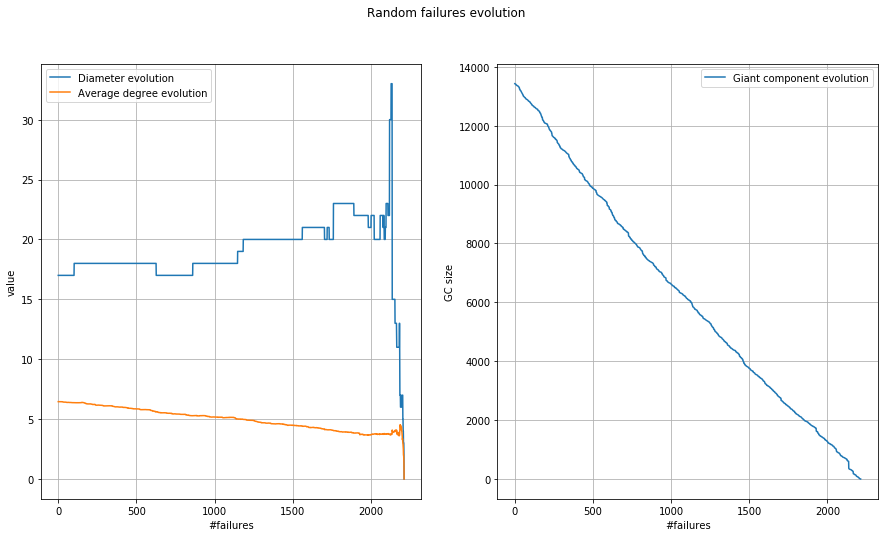

In [11]:
attackDict["Random"] = rand_failures["Giant component evolution"]
plot_distribution(rand_failures, "Random")

From the plot, we can observe that more or less 50% of the nodes need to be removed randomly in order to break the giant component; this percentage is quite smaller respect to the one that we could expect from a scale-free network (80%).

### -- attacks over closeness

In [8]:
cls_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.closeness_centrality})

Iteration 1:	Graph size 4154	Diameter: 17
Iteration 2:	Graph size 4153	Diameter: 17
Iteration 3:	Graph size 4152	Diameter: 17
Iteration 4:	Graph size 4141	Diameter: 17
Iteration 5:	Graph size 4140	Diameter: 17
Iteration 6:	Graph size 4139	Diameter: 17
Iteration 7:	Graph size 4138	Diameter: 17
Iteration 8:	Graph size 4133	Diameter: 17
Iteration 9:	Graph size 4131	Diameter: 17
Iteration 10:	Graph size 4129	Diameter: 17
Iteration 11:	Graph size 4128	Diameter: 17
Iteration 12:	Graph size 4125	Diameter: 17
Iteration 13:	Graph size 4124	Diameter: 17
Iteration 14:	Graph size 4121	Diameter: 17
Iteration 15:	Graph size 4115	Diameter: 17
Iteration 16:	Graph size 4105	Diameter: 17
Iteration 17:	Graph size 4102	Diameter: 17
Iteration 18:	Graph size 4100	Diameter: 17
Iteration 19:	Graph size 4099	Diameter: 17
Iteration 20:	Graph size 4098	Diameter: 17
Iteration 21:	Graph size 4095	Diameter: 17
Iteration 22:	Graph size 4094	Diameter: 17
Iteration 23:	Graph size 4093	Diameter: 17
Iteration 24:	Graph 

Iteration 190:	Graph size 3541	Diameter: 24
Iteration 191:	Graph size 3539	Diameter: 24
Iteration 192:	Graph size 3538	Diameter: 26
Iteration 193:	Graph size 3531	Diameter: 26
Iteration 194:	Graph size 3529	Diameter: 26
Iteration 195:	Graph size 3521	Diameter: 26
Iteration 196:	Graph size 3515	Diameter: 26
Iteration 197:	Graph size 3514	Diameter: 26
Iteration 198:	Graph size 3513	Diameter: 26
Iteration 199:	Graph size 3510	Diameter: 26
Iteration 200:	Graph size 3509	Diameter: 26
Iteration 201:	Graph size 3507	Diameter: 26
Iteration 202:	Graph size 3505	Diameter: 26
Iteration 203:	Graph size 3502	Diameter: 28
Iteration 204:	Graph size 3501	Diameter: 28
Iteration 205:	Graph size 3500	Diameter: 28
Iteration 206:	Graph size 3498	Diameter: 28
Iteration 207:	Graph size 3492	Diameter: 28
Iteration 208:	Graph size 3491	Diameter: 28
Iteration 209:	Graph size 3488	Diameter: 28
Iteration 210:	Graph size 3487	Diameter: 28
Iteration 211:	Graph size 3484	Diameter: 28
Iteration 212:	Graph size 3472	D

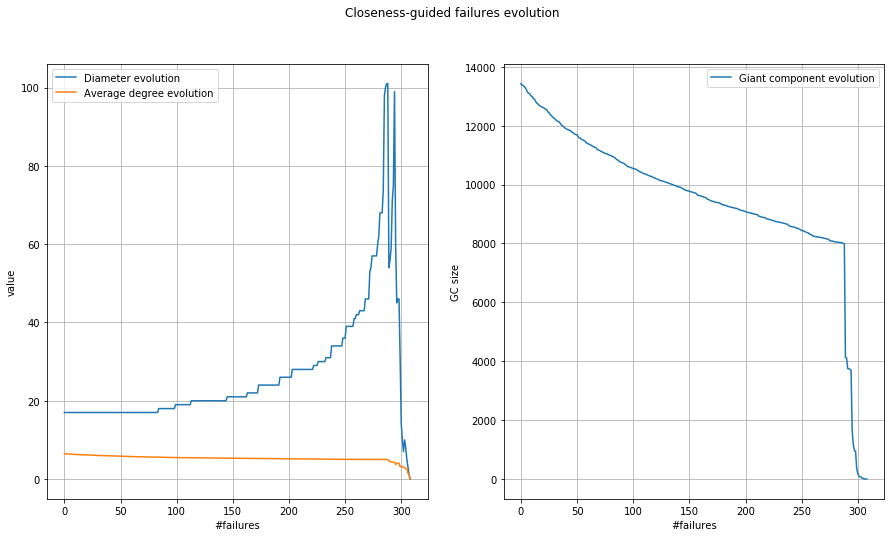

In [9]:
attackDict["Closeness"] = cls_failures["Giant component evolution"]
plot_distribution(cls_failures, "Closeness-guided")

### -- attacks over betweenness

In [6]:
btw_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.betweenness_centrality})

Iteration 1:	Graph size 4154	Diameter: 17
Iteration 2:	Graph size 4144	Diameter: 17
Iteration 3:	Graph size 4133	Diameter: 17
Iteration 4:	Graph size 4128	Diameter: 17
Iteration 5:	Graph size 4122	Diameter: 17
Iteration 6:	Graph size 4121	Diameter: 17
Iteration 7:	Graph size 4104	Diameter: 17
Iteration 8:	Graph size 4103	Diameter: 17
Iteration 9:	Graph size 4102	Diameter: 17
Iteration 10:	Graph size 4098	Diameter: 17
Iteration 11:	Graph size 4097	Diameter: 17
Iteration 12:	Graph size 4092	Diameter: 17
Iteration 13:	Graph size 4090	Diameter: 17
Iteration 14:	Graph size 4085	Diameter: 17
Iteration 15:	Graph size 4083	Diameter: 17
Iteration 16:	Graph size 4082	Diameter: 17
Iteration 17:	Graph size 4080	Diameter: 17
Iteration 18:	Graph size 4077	Diameter: 17
Iteration 19:	Graph size 4075	Diameter: 17
Iteration 20:	Graph size 4074	Diameter: 17
Iteration 21:	Graph size 4059	Diameter: 17
Iteration 22:	Graph size 4058	Diameter: 17
Iteration 23:	Graph size 4057	Diameter: 17
Iteration 24:	Graph 

Iteration 190:	Graph size 2848	Diameter: 29
Iteration 191:	Graph size 2840	Diameter: 29
Iteration 192:	Graph size 2837	Diameter: 29
Iteration 193:	Graph size 2834	Diameter: 30
Iteration 194:	Graph size 2815	Diameter: 34
Iteration 195:	Graph size 2814	Diameter: 34
Iteration 196:	Graph size 2813	Diameter: 37
Iteration 197:	Graph size 2668	Diameter: 29
Iteration 198:	Graph size 2666	Diameter: 29
Iteration 199:	Graph size 2664	Diameter: 29
Iteration 200:	Graph size 2657	Diameter: 29
Iteration 201:	Graph size 2644	Diameter: 29
Iteration 202:	Graph size 2632	Diameter: 29
Iteration 203:	Graph size 2631	Diameter: 29
Iteration 204:	Graph size 2630	Diameter: 29
Iteration 205:	Graph size 2628	Diameter: 29
Iteration 206:	Graph size 2619	Diameter: 29
Iteration 207:	Graph size 2615	Diameter: 30
Iteration 208:	Graph size 2599	Diameter: 30
Iteration 209:	Graph size 2586	Diameter: 30
Iteration 210:	Graph size 2583	Diameter: 30
Iteration 211:	Graph size 2577	Diameter: 30
Iteration 212:	Graph size 2575	D

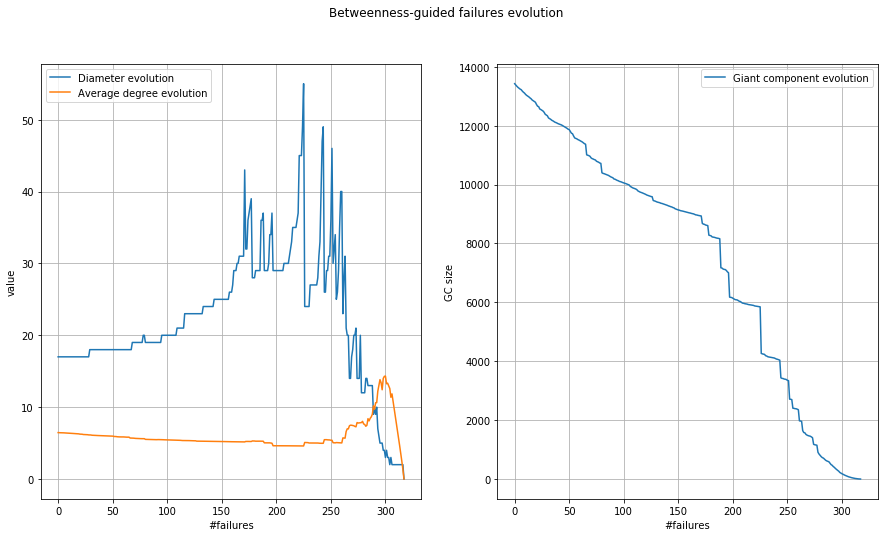

In [7]:
attackDict["Betweenness"] = btw_failures["Giant component evolution"]
plot_distribution(btw_failures, "Betweenness-guided")

### -- attacks over nodes degree

In [ ]:
deg_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.degree})

In [ ]:
attackDict["Degree"] = deg_failures["Giant component evolution"]
plot_distribution(deg_failures, "Closeness-guided")

### -- attacks over clustering coefficient

In [ ]:
clt_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.clustering})

In [ ]:
attackDict["Clustering"] = clt_failures["Giant component evolution"]
plot_distribution(clt_failures, "Clustering-guided")

### -- attacks over pagerank

In [ ]:
prk_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.pagerank_numpy})

In [ ]:
attackDict["Pagerank"] = prk_failures["Giant component evolution"]
plot_distribution(prk_failures, "Pagerank-guided")

### -- attacks over hits (hubs or authorities)

In [ ]:
hit_failures = execute_failures_pool(G, metric_ranking, {'metricFunction':nx.hits_numpy, 'index':0})

In [ ]:
attackDict["HITS"] = hit_failures["Giant component evolution"]
plot_distribution(hit_failures, "HITS-guided")

As we could have expected, the betweenness index is greatly significative in the node choice in order to obtain the maximum connection disruption: just 200 nodes over 4158	(5%) are sufficient for breaking the giant component in several small groups; interesting enough, the components obtained after the removal of a certain amount of edges show a significant increase in the average degree (this could prove the existence of several strongly connected communities inside the starting giant component).

On the other hand, the pick in the diameter values reached by the closeness index is nearly doubled respect to the one obtained by the other attack: it is not able to break the giant component equally fast, but it greatly increases the average path distance between two far nodes for intermediate stages.

### -- attack comparison

In [ ]:
compare_attack(attackDict, "real")

# Others outdated methods

In [ ]:
def execute_failures_2processes(graph, rankFunction, rankParams={}):
    workingG = max(nx.connected_component_subgraphs(graph), key=len)
    i = 0
    
    diam_evol = multiprocessing.Manager().dict({i:nx.diameter(workingG)})
    deg_evol = multiprocessing.Manager().dict({i:np.mean(list(dict(workingG.degree).values()))})
    giant_evol = multiprocessing.Manager().dict({i:workingG.size()})
    
    while len(workingG)>1:        
        node = rankFunction(workingG, **rankParams)
        workingG.remove_node(node)
        workingG = max(nx.connected_component_subgraphs(workingG), key=len)
        
        i+=1

        if (i%2==1):
            t1 = multiprocessing.Process(target=work, args=(workingG.copy(), i, diam_evol, deg_evol, giant_evol))
            p=t1
            t1.start()
            if(i!=1):
                t2.join()
        else:
            t2 = multiprocessing.Process(target=work, args=(workingG.copy(), i, diam_evol, deg_evol, giant_evol))
            p=t2
            t2.start()
            t1.join()
            
    p.join()
    
    diam_evol=list(map(lambda p:p[1], sorted(diam_evol.items(), key=lambda p:p[0])))
    deg_evol=list(map(lambda p:p[1], sorted(deg_evol.items(), key=lambda p:p[0])))
    giant_evol=list(map(lambda p:p[1], sorted(giant_evol.items(), key=lambda p:p[0])))
    
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}

def execute_failures_connected(graph, rankFunction, rankParams={}):
    workingG = max(nx.connected_component_subgraphs(graph), key=len)
    diam_evol = [nx.diameter(workingG)]
    deg_evol = [np.mean(list(dict(workingG.degree).values()))]
    giant_evol = [len(workingG)]
    
    while len(workingG)>1:
        node = rankFunction(workingG, **rankParams)
        workingG.remove_node(node)
        if nx.is_connected(workingG):
            diam_evol.append(nx.diameter(workingG))
            giant_evol.append(len(workingG))
        else:
            diam_evol.append(0)
            giant_evol.append(0)
        
        deg_evol.append(np.mean(list(dict(workingG.degree).values())))
        
         
    return {"Diameter evolution":diam_evol,
            "Average degree evolution":deg_evol,
            "Giant component evolution":giant_evol}